In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from scipy import stats
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from functools import partial

# Data
from data.data_generator import data_generator
from data.data_generator import data_model
from data.data_filtering import (sanity_checks, est_sanity_checks)

# Model
from models.models import HeteroskedasticModel
from models.models import BayesFlow

# Utils
from utils.losses import heteroskedastic_loss, maximum_likelihood_loss
from utils.training import train_step
from utils.viz import (plot_true_est_scatter, plot_true_est_posterior, 
                       plot_correlation_parameters, plot_comp_post_prior, plot_ppc)

%load_ext autoreload
%autoreload 2

In [2]:
# Using Heteroskedastic model as summary net
class SummaryNet(tf.keras.Model):
    def __init__(self, meta):
        super(CustomSummaryNetwork, self).__init__()
        pass
    
    def call(self, x):
        """
        Performs a forward pass through the summary network
        Arguments:
        x : tf.Tensor of shape (batch_size, n_obs, x_dim) - a batch of samples from p(x|params)
        """
        
        # Do something with input
        
        return x

### Training hyperparameters

In [3]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5

# Optional if using the predefined summary nets
summary_meta = {
    'n_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}


# Forward model hyperparameters
parameter_names = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$\delta$', r'$\rho$']
theta_dim = len(parameter_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "SEIDR"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000

starter_learning_rate = 0.001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)

### Test Data

In [4]:
%%time
data_test = data_generator(n_test)

# Preprocessing untrained data
x_test = np.array(data_test['x'])
theta_test = np.array(data_test['theta'])

CPU times: user 145 ms, sys: 4.01 ms, total: 149 ms
Wall time: 147 ms


In [5]:
print(type(x_test))
print(x_test.shape)
print(type(theta_test))
print(theta_test.shape)

<class 'numpy.ndarray'>
(500, 100, 5)
<class 'numpy.ndarray'>
(500, 5)


In [6]:
# Sanity checks
x_test, theta_test = sanity_checks(x_test, theta_test)

# Sanity checks for numerical stability
assert(np.sum(x_test == np.inf) == 0)
assert(np.sum(x_test == -np.inf) == 0)
assert(np.sum(x_test == np.nan) == 0)

# Reshape x
x_test = x_test.reshape(x_test.shape[0], -1)

In [7]:
print(x_test.shape)
print(theta_test.shape)

(500, 500)
(500, 5)


### Networks

In [8]:
# Instantiate model
summary_net = HeteroskedasticModel(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

### Compile

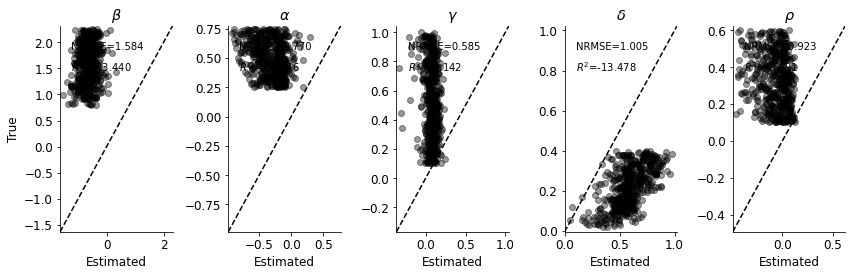

In [9]:
plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, parameter_names, figsize=(12, 4))

### Manage Checkpoints

In [10]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/SEIDR/ckpt-712


### Training network

In [ ]:
# %%time
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_step(model=model, 
                            optimizer=optimizer,
                            loss_fn=maximum_likelihood_loss, 
                            iterations=iterations_per_epoch,
                            batch_size=batch_size,
                            p_bar=p_bar,
                            global_step=global_step) 

        # Manage checkpoint
        manager.save()

### Posterior means & Full posteriors

In [11]:
x_test.shape

(500, 500)

In [12]:
# Estimation sanity checks
theta_samples = model.sample(x_test, n_samples_posterior, to_numpy=True)
theta_approx_means = theta_samples.mean(axis=0)

In [13]:
ftheta_approx_means, ftheta_test, fx_test = est_sanity_checks(theta_approx_means, theta_test, x_test=x_test)

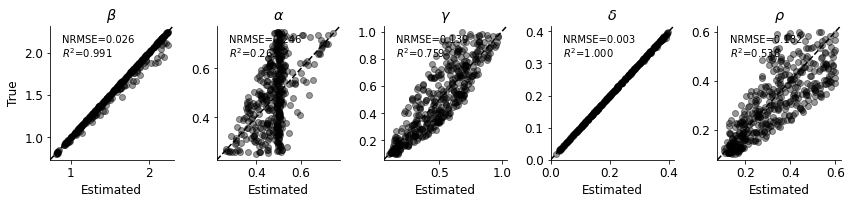

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


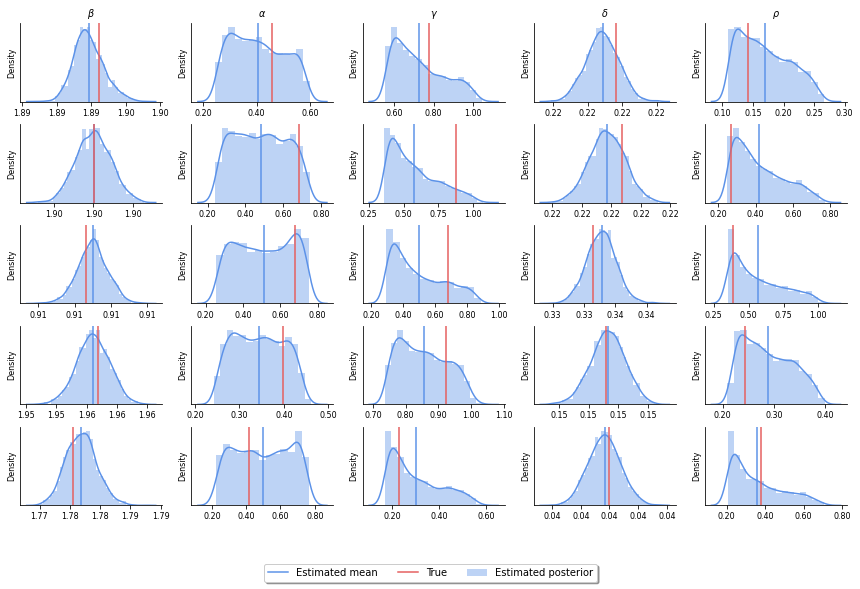

In [14]:
plot_true_est_scatter(model, fx_test, ftheta_test, n_samples_posterior, parameter_names, figsize=(12, 3), theta_approx_means=ftheta_approx_means)

plot_true_est_posterior(model, 2000, parameter_names, font_size=8,
                        X_test=fx_test[:5], 
                        theta_test=ftheta_test[:5], figsize=(12, 8))

In [15]:
# Posteriors of randomly selected sample
rand_sample_idx = np.random.choice(theta_samples.shape[0], 1, replace=False)
sel_sample = theta_samples[rand_sample_idx].squeeze()

In [16]:
sel_sample.shape

(500, 5)

In [17]:
fsel_sample, ftheta_test, fx_test = est_sanity_checks(sel_sample, theta_test, x_test)

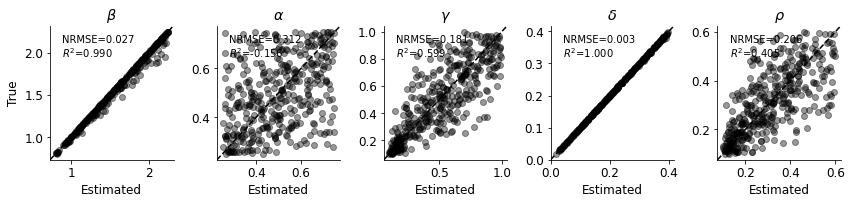

In [18]:
plot_true_est_scatter(model, fx_test, ftheta_test, n_samples_posterior, parameter_names, figsize=(12, 3), theta_approx_means=fsel_sample)

### Correlation of parameters

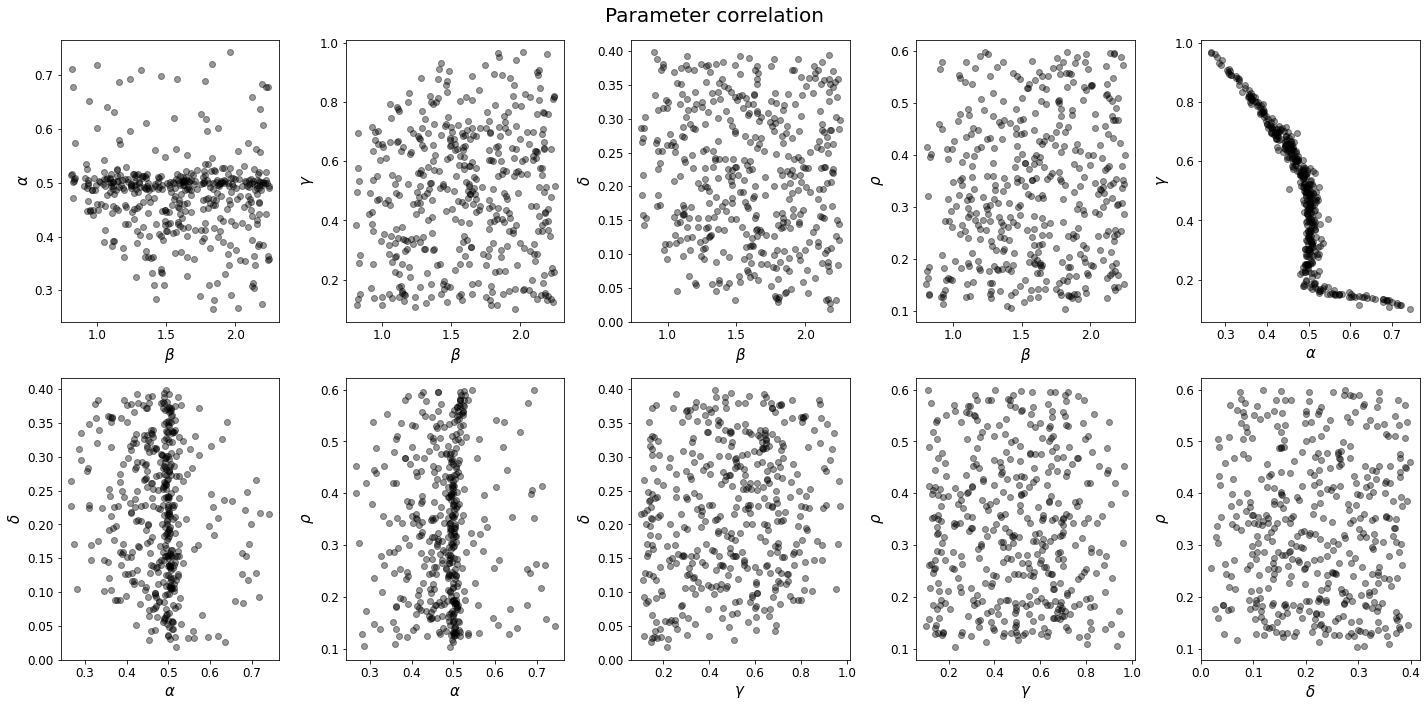

<Figure size 1440x720 with 0 Axes>

In [19]:
plot_correlation_parameters(ftheta_approx_means, parameter_names)

### Re-simulation

In [20]:
# Forward model using selected sample
t_obs = 100
dt = 1
t = np.linspace(0, t_obs, int(t_obs/dt))
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0
forward_model = partial(data_model, initial_values=init_vals)

ts = np.empty((fsel_sample.shape[0], t_obs, 5))
          
for i in range(fsel_sample.shape[0]):
    ts[i, :, :] = forward_model(fsel_sample[i, :], t=t)

ts = ts.reshape(fsel_sample.shape[0], -1)

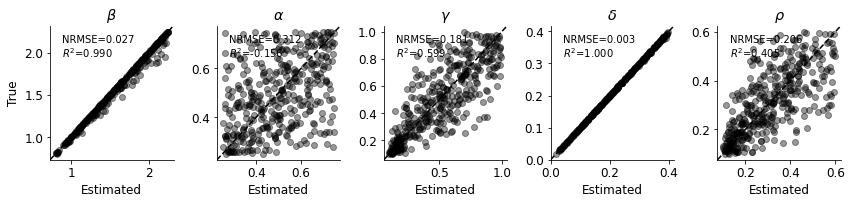

In [21]:
plot_true_est_scatter(model, ts, ftheta_test, n_samples_posterior, parameter_names, figsize=(12, 3), theta_approx_means=fsel_sample)

### Compartiment time series of randomly selected sample

In [22]:
# Estimation sanity check
rand_params_index = np.random.choice(fsel_sample.shape[0], 1, replace=False)
sel_params = fsel_sample[rand_params_index].squeeze()

In [23]:
parameters = sel_params

ts = forward_model(parameters, t=t)
labels = ['S', 'E', 'I', 'R', 'D']

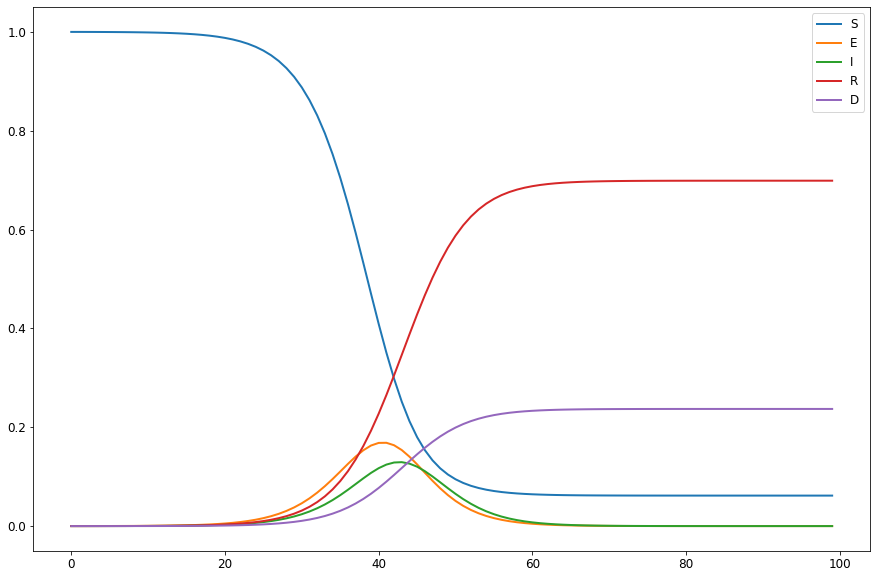

In [24]:
f, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(5):
    ax.plot(ts[:, i], label=labels[i], lw=2)
    
plt.legend()

# ts_t = tf.convert_to_tensor(ts[np.newaxis].reshape(1, -1), dtype=tf.float32)


# theta_hat = model.sample(ts_t, 5000, to_numpy=True)

# f, axarr = plt.subplots(1, 5, figsize=(12, 3))
# for i in range(5):
#     sns.distplot(theta_hat[:, i], ax=axarr[i], kde=False)
#     axarr[i].axvline(parameters[i], color='black')
    
# f.tight_layout()

### Plot predictions

The idea is to filter the theta_samples with the sanity checks and set invalid tuples to None

Then, calculate time series with forward modelfor all non-NaN parameter tuples

In [25]:
theta_samples.shape

(2000, 500, 5)

In [26]:
idxs = []
for i in range(theta_samples.shape[0]):
    _, _, mask_idx = est_sanity_checks(theta_samples[i, :, :], theta_test, idx_mask=True)
    idxs.append(np.unique(mask_idx))

In [ ]:
# Set invalid parameters to None
for i in range(theta_samples.shape[0]):
    theta_samples[i, :, :][idxs[i]] = None

In [ ]:
theta_samples[0, 1]

In [ ]:
# Calculate time series with forward model for non-NaN parameters of n random samples
n = 20
rand_idx = np.sort(np.random.choice(theta_samples.shape[0], n, replace=False))
t = np.linspace(0, t_obs, int(t_obs/dt))
ts = np.empty((n, theta_samples.shape[1], t_obs, 5))
ts[:, :, :, :] = np.NaN

# Filter theta_samples with random index
ftheta_samples = theta_samples[rand_idx]

In [ ]:
for i in range(ftheta_samples.shape[0]):
    for j in range(ftheta_samples.shape[1]):
        if np.isnan(ftheta_samples[i, j, :].sum()) == False:
            ts[i, j, :, :] = forward_model(theta_samples[i, j, :], t=t)

In [ ]:
cmap = cm.Blues
plot_ppc(t, ts, labels, ci='b')